<a href="https://colab.research.google.com/github/AlkaidCheng/GSoC2021_QMLHEP/blob/main/notebooks/TaskII_QuantunGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NOTE: USE OF GPU MAY SPEED THINGS UP**

In [1]:
if 'google.colab' in str(get_ipython()):
  # install packages needed for this task
  !pip install tensorflow==2.3.1
  !pip install tensorflow_quantum==0.4.0
  !pip install quple==0.6.9

     |████████████████████████████████| 320.4MB 52kB/s 
     |████████████████████████████████| 460kB 21.0MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


     |████████████████████████████████| 5.9MB 7.8MB/s 
     |████████████████████████████████| 5.6MB 55.6MB/s 
     |████████████████████████████████| 1.6MB 56.5MB/s 
  Found existing installation: sympy 1.7.1
    Uninstalling sympy-1.7.1:
      Successfully uninstalled sympy-1.7.1
     |████████████████████████████████| 81kB 5.9MB/s 


# GSoC Task II - Quantum Generative Adversarial Network (QGAN)

## Introduction

### On the theory and motivation behind QGAN

- On general quantum machine learning:
    - A quantum neural network typical is achieved by building **parameterised quantum circuit (PQC)** with the neural network weights encoded as parameters of quantum gates which typically represents a rotation of the quantum state about some linear combination of basis state. 
    - Another important aspect is the encoding of classical data into the qubit states of a quantum circuit. A major source of quantum advantage comes from the high dimensional Hilbert space that qubits lived in which can translated as the feature space of the input data or the phase space of a neural network. 
    - For an actual hardware, the quantum feature of qubits existing as a linear combination of $2^N$ basis states where $N$ is the number of qubits together with the feature of collapse of wavefunction at measurement makes it possible to perform parallel computation of vast number of inputs (ideally $2^N$ of them) to achieve a better time complexity. 

- On quantum GAN:

    - Major reference: https://arxiv.org/abs/1901.00848

    - The essence of a quantum version of the Generative Adversarial Network (GAN) is to replace the general and discriminator neural network by a quantum neural network made up of parameterised quantum circuits.

    - Assuming that the **discriminator** and the **generator** have infinite capacity, which means that ideally they can **represent any probability distribution**, then it is possible to construct a neural network whose final state reaches a Nash equilibrium where the **generator produces data that corresponds to the observed probability distribution, and the discriminator has 0.5 probability of discriminating correctly**. Therefore, the final result of the GAN is a generator model that produces samples from the observed distribution by sampling the prior distribution $p_z(z)$. The space of $z$ is usually called the latent space, and the generator $F_G$ is to map samples from the latent space to the output space $x$.

### On the packages used
- In this task, we wil be using the `quple` package for **parameterised quantum circuit (PQC) construction**. `quple` is a package developed by myself in last year's GSoC project related to Varational Quantum Classifier (VQC) and has been extended to more machine learning algorithms. The package is based on the Google `cirq` and `tensorflow_quantum` library.

- For the actual model construction and training, we will be using the Google `tensorflow_quantum` library. It is responsible for **constructing the neural network layers, loss function and gradient calculation**.

### Current challenges

- In the native way of implementing quantum neural network layers (called PQC) using `tensorflow_quantum` (at least according to their tutorials), the input to the PQC layer is a data encoding quantum circuit that has the classical data already encoded into the parameters of the circuit gate operations. This circuit is converted to a tensorflow string and passed as an input to the PQC layer. However, this causes problem in **gradient calculation** that involves output from multiple neural networks, i.e. generator and discrminator in this case. Since the generator output is a tensor of the classical input which needs to be encoded into a data encoding circuit and then to a tensorflow string, in this process the **gradient information with respect to the generator weights is lost and can not be passed to the discriminator (i.e. no back propagation)**. To circumvent this I implemented my custom PQC layer in my own package `quple` which takes in tensor with classical data instead of tensor with the data encoding circuit in the string representation. This is achieved by combining the data encoding circuit and the parameterised circuit as a whole and resolve the symbol values of both circuits all together. However, there is a current limitation from `tensorflow_quntum` that it cannot resolve symbol expression other than simple scalar multiplication which greatly limits the complexity of the data encoding circuit. The relevant code that causes the problem is: https://github.com/tensorflow/quantum/blob/master/tensorflow_quantum/core/serialize/serializer.py#L43

- `tensorflow_quantum` does not support second order differentiation of quantum layer therefore we can not use models that require second derivatives, for instance the **Wasserstein GAN with gradient penalty** (WGAN-GP). The relevant discussion can be found here: https://github.com/tensorflow/quantum/issues/285. 

In [2]:
# load some packages just to start
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

### Load Input
According to the task description:

- In the input file, there are only 100 samples for training and 100 samples for testing.
- The signal events are labeled with 1 while the background events are labeled with 0.

In [3]:
if 'google.colab' in str(get_ipython()):
  !wget https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/QIS_EXAM_200Events.npz

--2021-03-22 21:47:43--  https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/QIS_EXAM_200Events.npz
Resolving gitlab.cern.ch (gitlab.cern.ch)... 188.184.104.112, 188.184.116.40, 188.184.31.109, ...
Connecting to gitlab.cern.ch (gitlab.cern.ch)|188.184.104.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9140 (8.9K) [application/zip]
Saving to: ‘QIS_EXAM_200Events.npz’

QIS_EXAM_200Events. 100%[===================>]   8.93K  --.-KB/s    in 0s      

2021-03-22 21:47:44 (158 MB/s) - ‘QIS_EXAM_200Events.npz’ saved [9140/9140]



In [4]:
data = dict(np.load('QIS_EXAM_200Events.npz', allow_pickle=True))
x_train_bkg = data['training_input'].item()['0']
x_test_bkg = data['test_input'].item()['0']
x_train_sig = data['training_input'].item()['1']
x_test_sig = data['test_input'].item()['1']
# combine the signal and background samples
x_train = np.concatenate((x_train_sig, x_train_bkg))
y_train = np.concatenate((np.ones(x_train_sig.shape[0]), np.zeros(x_train_bkg.shape[0])))
x_test = np.concatenate((x_test_sig, x_test_bkg))
y_test = np.concatenate((np.ones(x_test_sig.shape[0]), np.zeros(x_test_bkg.shape[0])))

Here we follow the common scheme that each qubit encodes one feature

In [5]:
n_qubit = x_train.shape[1]
n_qubit 

5

In [6]:
print('Signal event shape: ', x_train_sig.shape)
print('Background event shape: ', x_train_bkg.shape)

Signal event shape:  (50, 5)
Background event shape:  (50, 5)


### Visualize variable distributions 

Let's check our target distribution that the generator should reproduce from noise

In [7]:
# Plot variable distributions for input
def make_plots(data, labels, binning=20, columns=3):
    X = [d.T for d in data]
    fig=plt.figure(figsize=(20, 10))
    rows =  1 + (X[0].shape[0] // columns)
    bins = np.histogram(np.hstack(tuple(X)), bins=binning)[1]
    plt.subplots_adjust(hspace=0.3)
    for i in range(X[0].shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Variable {}'.format(i+1), fontsize=15)
        for j, x in enumerate(X):
            ax.hist(x[i], bins=bins, alpha=.5, label=labels[j])
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.2), ncol=len(data), fontsize=10)
    plt.show()

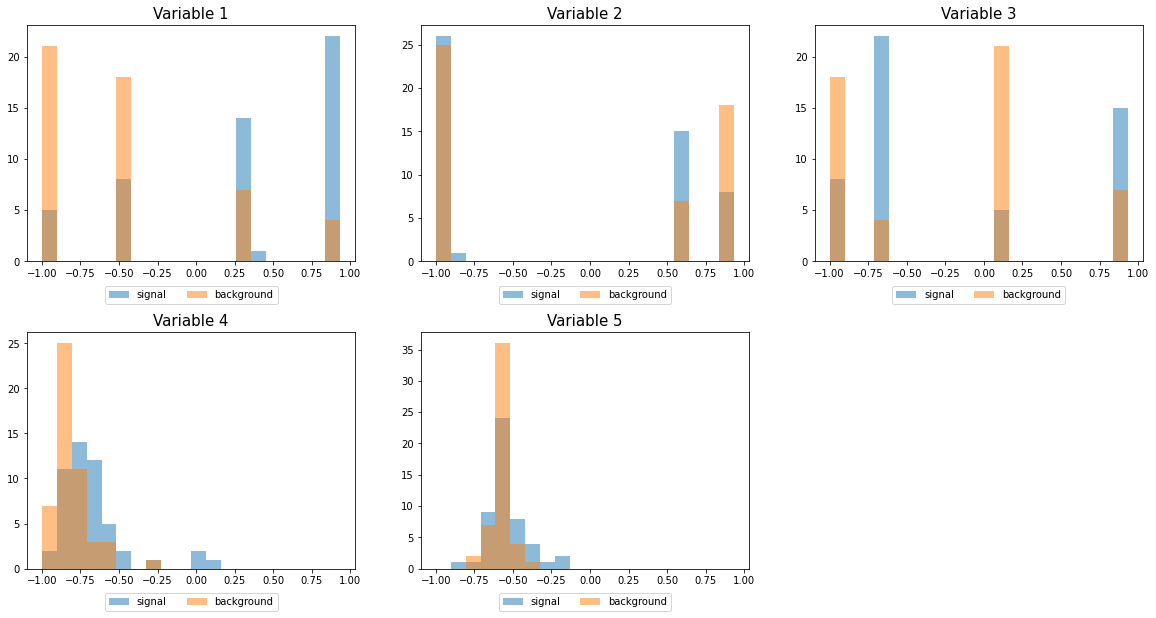

In [8]:
make_plots([x_train_sig, x_train_bkg], ['signal', 'background'])

Here we immediately spot the problem that distributions for variables 1, 2 and 3 are discrete. They probably represent some flag of an event such as the b-tagging score. Typically GAN is not good at dealing with non-continuous distribution, so we expect the **generator** will have a **hard time producing such distribution** from random noise. 

# Create Our QGAN model

- The main reference is https://arxiv.org/pdf/1901.00848.pdf which proposes the use of variational quantum circuits as generator and discriminators

- A **classical output layer** is used for both generator and discrminator. In this way, we can also implement an activation function to the final output. Therefore, this QGAN model is a **hybrid quantum-classical model** just like most quantum neural network implementations.

- By default, the **tanh** activation function is used for generator and **leaky RELU** with slope 0.2 is used for discrminator. Although in this notebook I used 'linear' instead which is also the standard activation function for discriminator.

- Here we use the **binary cross entropy loss**, which is the standard loss function from the original GAN paper

- The **Adam optimizer** is used for both generator and discrminator

- A `random_state` option is added to allow for reproducible result

In [9]:
from typing import Union, Optional
from functools import partial

import numpy as np
import cirq
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_quantum as tfq
from sklearn.metrics import roc_curve, auc, roc_auc_score

import quple
from quple.interface.tfq.layers.pqc import PQC
from quple.utils.utils import plot_roc_curve

class QGAN(object):
    """Quantum Generative Adversarial Network (QGAN)
    """    
    def __init__(self, generator_circuit:"cirq.Circuit", discriminator_circuit:"cirq.Circuit",
                 encoding_circuit:"cirq.Circuit",
                 epochs:int=100, batch_size:int=10,   
                 g_lr:float=1e-3, d_lr:float=1e-3, g_activation='tanh', 
                 d_activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                 g_readout=None,
                 d_readout=None,                 
                 differentiator:Optional[tfq.differentiators.Differentiator]=None,
                 regularizer=None,
                 repetitions=None,                 
                 random_state:Optional[int]=None, 
                 name:str='QGAN', *arg, **args):
        """ Creates a QGAN model equipped with a generator and a discriminator
            The only difference between WGAN and DCGAN is in the definition of
            the loss function and the discriminator step per generator step and
            possibly the choice of activation function
        Args:
            generator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum generator (VQG)
            discriminator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum discriminator (VQD)
            encoding_circuit: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit for data encoding             
            epochs: int, default=100
                Number of epochs
            batch_size: int, default=10
                Batch size for training
            g_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the generator
            d_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the discriminator
            g_activation: str/callable, default='sigmoid'
                Activation function for the output layer of generator
            d_activation: str/callable, default='tanh'
                Activation function for the output layer of discriminator 
            g_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator
                If None, defaults to Pauli Z on all qubits
            d_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator                     
                If None, defaults to Pauli Z on first qubit
            differentiator: Optional `tfq.differentiator` object 
                To specify how gradients of variational circuit should be calculated.
            regularizer: Optional `tf.keras.regularizer` object
                Regularizer applied to the parameters of the variational circuit.
            repetitions: int; default=None
                Number of repetitions for measurement           
            random_state: Optional int, default=None
                The random state for reproducible result.
            name: Optional str, default="QGAN"
                Name given to the classifier.                
        """
        # initialize hyperparameters first
        self.epochs = epochs
        self.batch_size = batch_size
        self.g_lr = g_lr
        self.d_lr = d_lr        
        self.g_activation = g_activation
        self.d_activation = d_activation
        self.differentiator = differentiator
        self.regularizer = regularizer
        self.repetitions = repetitions
        self.g_readout = g_readout
        self.d_readout = d_readout
        self.encoding_circuit = encoding_circuit
        # latent dimension is the same as number of features (= number of qubits)
        self.latent_dim = len(quple.get_circuit_qubits(encoding_circuit))
        self.random_state = random_state
        self.set_random_state(self.random_state)
        # create generator and discriminator models from parameterized quantum circuit
        self.G = self.create_generator(generator_circuit)
        self.D = self.create_discriminator(discriminator_circuit)
        # create optimizers
        self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=self.g_lr)
        self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=self.d_lr)
        
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        self.name = name
        
        print('Summary of Generator')
        self.G.summary()
        
        print('Summary of Discriminator')
        self.D.summary()
    
    @staticmethod
    def set_random_state(random_state=None):
        tf.random.set_seed(random_state)
        np.random.seed(random_state)        
        
    def create_generator(self, quantum_circuit:"cirq.Circuit"):
        generator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.g_readout:
            g_readout = [cirq.Z(qubit) for qubit in qubits]
        else:
            g_readout = self.g_readout
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        g_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for processing quantum output
        output_layer = tf.keras.layers.Dense(self.latent_dim, activation=self.g_activation)
        
        # create generator model
        generator.add(input_layer)
        generator.add(pqc_layer)
        generator.add(output_layer)
        return generator
    
    def create_discriminator(self, quantum_circuit:"cirq.Circuit"):
        discriminator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)        
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.d_readout:
            # by default measure PauliZ on first qubit
            d_readout = [cirq.Z(qubits[0])]
        else:
            d_readout = self.d_readout    
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        d_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for adding bias to the quantum output
        output_layer = tf.keras.layers.Dense(1, activation=self.d_activation)
        
        # create generator model
        discriminator.add(input_layer)
        discriminator.add(pqc_layer)
        discriminator.add(output_layer)
        return discriminator
    
    def D_loss(self, real_output, fake_output):
        """Compute discriminator loss."""
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def G_loss(self, fake_output):
        """Compute generator loss."""
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def to_prob(self, x):
        """Convert discriminator output to probabilities"""
        return tf.divide(tf.add(x, 1), 2)
    
    def train_step(self, x_real, real_noise=0.0):
        """Training step for one epoch"""
        noise = tf.random.normal([self.batch_size, self.latent_dim])
        #x_real_w_noise = tf.add(x_real, tf.random.normal(shape=x_real.shape, 
        #                                           mean=0.0, 
        #                                           stddev=real_noise, dtype=x_real.dtype))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            x_fake = self.G(noise, training=True)
            real_output = self.D(x_real, training=True)
            p_real = self.to_prob(real_output) 
            fake_output = self.D(x_fake, training=True)
            p_fake = self.to_prob(fake_output) 
            gen_loss = self.G_loss(p_fake)
            disc_loss = self.D_loss(p_real, p_fake)

        grad_gen = gen_tape.gradient(gen_loss, self.G.trainable_variables)
        grad_disc = disc_tape.gradient(disc_loss, self.D.trainable_variables)
        self.G_optimizer.apply_gradients(zip(grad_gen, self.G.trainable_variables))
        self.D_optimizer.apply_gradients(zip(grad_disc, self.D.trainable_variables))  
        return gen_loss, disc_loss
    
    @tf.function
    def generate_samples(self, batch_size):
        """Generates sample using random inputs."""
        z = tf.random.normal((batch_size, self.latent_dim))
        return self.G(z, training=False)  
    
    def predict(self, x):
        return self.D(x, training=False)
    
    @staticmethod
    def create_batches(x, batch_size, buffer_size=10000):
        batches = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)
        return batches
    
    def train(self, x, interactive_display=True):
        self.set_random_state(self.random_state)
        batches = self.create_batches(x, self.batch_size)
        #sample_size = x.shape[0]
        #z = tf.constant(tf.random.normal((sample_size, self.latent_dim)))
        g_metric = tf.keras.metrics.Mean()
        d_metric = tf.keras.metrics.Mean()
        fig = plt.figure(figsize=(16,9))
        g_loss_arr = []
        d_loss_arr = []
        epoch_arr = []
        
        for epoch in range(self.epochs):
            for batch in batches:
                gen_loss, disc_loss = self.train_step(batch)
                g_metric(gen_loss)
                d_metric(disc_loss)
                
            g_loss_arr.append(g_metric.result())
            d_loss_arr.append(d_metric.result())
            epoch_arr.append(epoch)
            if interactive_display:
                self.display_loss(g_loss_arr, d_loss_arr, epoch_arr)
            g_metric.reset_states()
            d_metric.reset_states()
        if not interactive_display:
            return g_loss_arr, d_loss_arr
    
    def test(self, x, y, plot=True):
        score = self.predict(x)
        fpr, tpr, thresholds = roc_curve(y, score)
        roc_auc = auc(fpr, tpr)
        if plot:
            return plot_roc_curve(fpr, tpr, 'QDCGAN')
        else:
            return roc_auc
        
    def display_loss(self, g_loss, d_loss, epochs):
        ax = plt.gca()
        ax.set_xlim(0, 1.1*epochs[-1])
        ax.cla()
        ax.plot(epochs, g_loss, label="Generator")
        ax.plot(epochs, d_loss, label="Discriminator")
        ax.set_xlabel('Epoch', fontsize=20)
        ax.set_ylabel('Binary Cross Entropy Loss', fontsize=20)
        ax.grid(True)
        ax.legend(fontsize=20)
        display(plt.gcf())
        clear_output(wait = True)    

# Construction of Quantum Circuits

For easy contruction of quantum circuits, we use the `ParameterisedCircuit` class from the `quple` module (a package made by the author of this notebook)

What does the `ParameterisedCircuit` class do?
- It uses a layered approach for applying quantum gates. A rotation layer consist of a single qubit gate applied to every qubit. An entanglement layer consist of multi-qubit gate applied to specific pairs/sets of qubits according to the `entangle_strategy`. 
- Parameters are automatically added to operations that requires it. Users can control whether to repeat the parameters at a certain stage. For the case of data encoding, the number of parameters should match the feature dimension which matches the number of qubits. Therefore, the parameters should repeat every layer. This is achieved by setting `reuse_param_per_layer` true.
- The argument `copies` is the **circuit depth**.
- The argument `rotation_blocks` specify a series of single qubit operations to be applied to each of the qubits.
- The argument `entanglement_blocks` specify a series of multiple qubit operations to be applied to a designated set of qubits
- The argument `entangle_strategy` specify the connectivity graph of the qubits. Here `alternate_linear` means every neighboring pair is connected but in an alternating manner.

In [10]:
# this will also load tfq which may take some time to initialize
from quple import ParameterisedCircuit

# Quantum Data Encoding

For encoding classical data into the qubits of a quantum circuit. The choice of circuit is kind of arbitray but it should start with Hadamard gate to map the qubit into computational basis ($X$-axis)

A simple entanglement with `CX` is used just to give it some complexity boost

In [11]:
encoding_circuit = ParameterisedCircuit(n_qubit, copies=2,
                                        rotation_blocks=['H', 'RZ', 'RY'],
                                        entanglement_blocks=['CX'],
                                        parameter_symbol='x',
                                        reuse_param_per_layer=True,
                                        entangle_strategy='alternate_linear')
encoding_circuit

(0, 0): ───H───Rz(x_0)───Ry(x_0)───@───H───Rz(x_0)───Ry(x_0)─────────────@───────
                                   │                                     │
(0, 1): ───H───Rz(x_1)───Ry(x_1)───X───@───H─────────Rz(x_1)───Ry(x_1)───X───@───
                                       │                                     │
(0, 2): ───H───Rz(x_2)───Ry(x_2)───@───X───H─────────Rz(x_2)───Ry(x_2)───@───X───
                                   │                                     │
(0, 3): ───H───Rz(x_3)───Ry(x_3)───X───@───H─────────Rz(x_3)───Ry(x_3)───X───@───
                                       │                                     │
(0, 4): ───H───Rz(x_4)───Ry(x_4)───────X───H─────────Rz(x_4)───Ry(x_4)───────X───

# Quantum Variational Generator (QVG)

For creating the variational circuit, we used the existing template from the `quple` package

- The `IsingCoupling` class is a PQC with a layer of `RY` and `RZ` rotation followed by a layer of `XX` Ising coupling gates. We can customize the ising coupling gates but for the moment we will use the defaults.

- Again, the choice is arbitrary. Just make it complex enough so it has some parameters to learn and the phase space is not too trivial (so good idea to have entanglement). 

In [12]:
from quple.circuits.variational_circuits import IsingCoupling, EfficientSU2
generator_circuit = IsingCoupling(n_qubit=n_qubit, copies=3,
                                  entangle_strategy='full')

In [13]:
generator_circuit

┌──────────────────┐               ┌──────────────────┐                                                                          ┌──────────────────┐               ┌──────────────────┐                                                                          ┌──────────────────┐               ┌──────────────────┐
(0, 0): ───Ry(θ_0)───Rz(θ_5)───XX──────────XX──────────XX───────────XX───────────────────────────────────────────────────────────────────Ry(θ_20)────Rz(θ_25)───XX──────────XX──────────XX───────────XX───────────────────────────────────────────────────────────────────Ry(θ_40)────Rz(θ_45)───XX──────────XX──────────XX───────────XX───────────────────────────────────────────────────────────────────Ry(θ_60)────Rz(θ_65)──────────────
                               │           │           │            │                                                                                           │           │           │            │                                                                                           │           │           │            │
(0, 1): ───Ry(θ_1)───Rz(θ_6)───XX^(θ_10)───┼───────────┼────────────┼────────XX───────────XX───────────XX────────────────────────────────Ry(θ_21)────Rz(θ_26)───XX^(θ_30)───┼───────────┼────────────┼────────XX───────────XX───────────XX────────────────────────────────Ry(θ_41)────Rz(θ_46)───XX^(θ_50)───┼───────────┼────────────┼────────XX───────────XX───────────XX────────────────────────────────Ry(θ_61)────Rz(θ_66)──────────────
                                           │           │            │        │            │            │                                                                    │           │            │        │            │            │                                                                    │           │            │        │            │            │
(0, 2): ───Ry(θ_2)───Rz(θ_7)───────────────XX^(θ_11)───┼────────────┼────────XX^(θ_14)────┼────────────┼────────XX───────────XX──────────Ry(θ_22)────Rz(θ_27)───────────────XX^(θ_31)───┼────────────┼────────XX^(θ_34)────┼────────────┼────────XX───────────XX──────────Ry(θ_42)────Rz(θ_47)───────────────XX^(θ_51)───┼────────────┼────────XX^(θ_54)────┼────────────┼────────XX───────────XX──────────Ry(θ_62)────Rz(θ_67)──────────────
                                                       │            │                     │            │        │            │                                                          │            │                     │            │        │            │                                                          │            │                     │            │        │            │
(0, 3): ───Ry(θ_3)───Rz(θ_8)───────────────────────────XX^(θ_12)────┼─────────────────────XX^(θ_15)────┼────────XX^(θ_17)────┼───────────XX──────────Ry(θ_23)───Rz(θ_28)────────────────XX^(θ_32)────┼─────────────────────XX^(θ_35)────┼────────XX^(θ_37)────┼───────────XX──────────Ry(θ_43)───Rz(θ_48)────────────────XX^(θ_52)────┼─────────────────────XX^(θ_55)────┼────────XX^(θ_57)────┼───────────XX──────────Ry(θ_63)───Rz(θ_68)───
                                                                    │                                  │                     │           │                                                           │                                  │                     │           │                                                           │                                  │                     │           │
(0, 4): ───Ry(θ_4)───Rz(θ_9)────────────────────────────────────────XX^(θ_13)──────────────────────────XX^(θ_16)─────────────XX^(θ_18)───XX^(θ_19)───Ry(θ_24)───Rz(θ_29)─────────────────────────────XX^(θ_33)──────────────────────────XX^(θ_36)─────────────XX^(θ_38)───XX^(θ_39)───Ry(θ_44)───Rz(θ_49)─────────────────────────────XX^(θ_53)──────────────────────────XX^(θ_56)─────────────XX^(θ_58)───XX^(θ_59)───Ry(θ_64)───Rz(θ_69)───
                                                               

# Quantum Variational Discriminator (QVD)
- `PauliBlock` refers to N-dimentional Pauli rotation, e.g. Pauli string of `Z` refers to `RZ` rotation of single qubit and `ZZ` refers to `RZZ` rotation about the Z axis of tensor product of two qubits
- Again, the choice is arbitrary. Just make it complex enough so it has some parameters to learn and the phase space is not too trivial (so good idea to have entanglement). 

In [14]:
from quple import PauliBlock

In [15]:
discriminator_circuit = ParameterisedCircuit(n_qubit=n_qubit, copies=3,
                                             rotation_blocks=['RZ', 'RY'],
                                             entanglement_blocks = [PauliBlock('ZZ'), PauliBlock('XX')],
                                             entangle_strategy='alternate_linear')

In [16]:
discriminator_circuit

(0, 0): ───Rz(θ_0)───Ry(θ_5)───@──────────────@────────────────────────────────────────H───@──────────────@───H────────────────────────────────────────────────────────────────────────Rz(θ_18)───Ry(θ_23)───@─────────────────────@────────────────────────────────────────H───@──────────────@───H────────────────────────────────────────────────────────────────────────Rz(θ_36)───Ry(θ_41)───@─────────────────────@────────────────────────────────────────H───@──────────────@───H────────────────────────────────────────────────────────────────────────────
                               │              │                                            │              │                                                                                                  │                     │                                            │              │                                                                                                  │                     │                                            │              │
(0, 1): ───Rz(θ_1)───Ry(θ_6)───X───Rz(θ_10)───X──────────────@──────────────@──────────H───X───Rz(θ_14)───X───H──────────────────────H───────@──────────────@───H──────────────────────Rz(θ_19)───Ry(θ_24)───X──────────Rz(θ_28)───X──────────────@──────────────@──────────H───X───Rz(θ_32)───X───H──────────────────────H───────@──────────────@───H──────────────────────Rz(θ_37)───Ry(θ_42)───X──────────Rz(θ_46)───X──────────────@──────────────@──────────H───X───Rz(θ_50)───X───H──────────────────────H───────@──────────────@───H──────────────────────────
                                                             │              │                                                                │              │                                                                                     │              │                                                                │              │                                                                                     │              │                                                                │              │
(0, 2): ───Rz(θ_2)───Ry(θ_7)───@─────────────────────────@───X───Rz(θ_12)───X─────────────────────────────────H───@──────────────@───H───H───X───Rz(θ_16)───X───H──────────────────────Rz(θ_20)───Ry(θ_25)──────────────@─────────────────────@───X───Rz(θ_30)───X─────────────────────────────────H───@──────────────@───H───H───X───Rz(θ_34)───X───H──────────────────────Rz(θ_38)───Ry(θ_43)──────────────@─────────────────────@───X───Rz(θ_48)───X─────────────────────────────────H───@──────────────@───H───H───X───Rz(θ_52)───X───H──────────────────────────
                               │                         │                                                        │              │                                                                                      │                     │                                                        │              │                                                                                      │                     │                                                        │              │
(0, 3): ───Rz(θ_3)───Ry(θ_8)───X──────────────Rz(θ_11)───X───@─────────────────────────@──────────────────────H───X───Rz(θ_15)───X───H──────────────────────────H───@──────────────@───H──────────Rz(θ_21)───Ry(θ_26)───X──────────Rz(θ_29)───X───@─────────────────────────@──────────────────────H───X───Rz(θ_33)───X───H──────────────────────────H───@──────────────@───H──────────Rz(θ_39)───Ry(θ_44)───X──────────Rz(θ_47)───X───@─────────────────────────@──────────────────────H───X───Rz(θ_51)───X───H──────────────────────────H───@──────────────@───H───
                                                             │                         │                                                                            │              │                                                              │                         │                                                

### Create the QGAN model

- Here the hyperparameters are kind of arbitrarily chosen. I just play with a few and pick one that looks good to me. I will do tuning later in this notebook

- For sake of demonstration, 100 epoch should be enough. In most cases, the generator and discrminator starts to ready out at 100 epochs (for this particular construction).

In [17]:
qgan = QGAN(generator_circuit, discriminator_circuit, encoding_circuit=encoding_circuit,
              epochs=100, d_lr=7e-3, g_lr=1e-3, g_activation='tanh', d_activation='linear',
              random_state=2)

Summary of Generator
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 5)                 70        
_________________________________________________________________
dense (Dense)                (None, 5)                 30        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 54        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 56
Trainable params: 56
Non-trainable params: 0
____________________________________________________________

### Start the training

- Here we **only train on the signal samples** so that the discriminator tries to discrminate between samples that are signals and samples that are not (**not necessarily the background**)

- We can't train with dataset with both signal and background because then the discriminator will just learn the joint distribution of the two which is not good for classification.

- One can also choose to train on background samples. Given the small sample size, choosing either one won't matter much

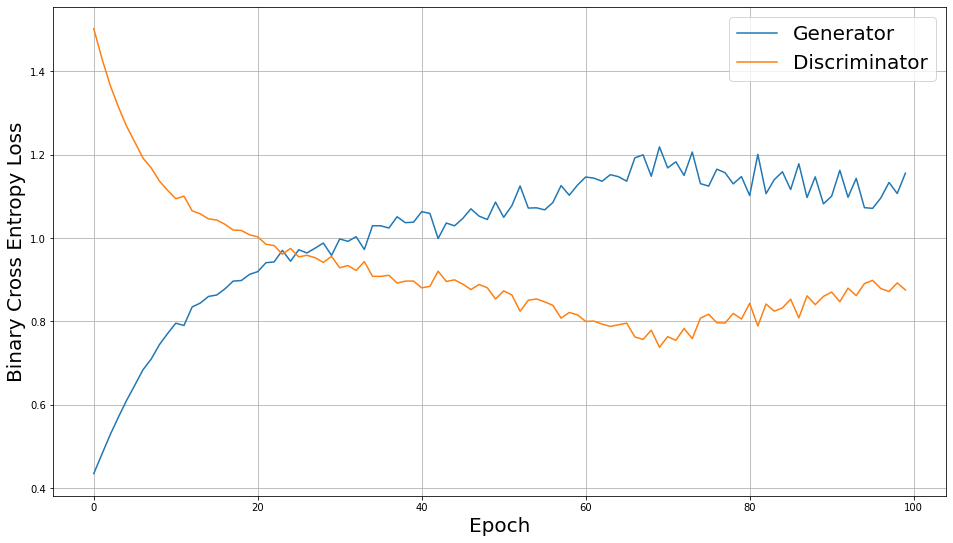

In [18]:
qgan.train(x_train_sig)

### Comments on the loss curve

- We can see that the **generator loss increases with time** whereas the **discrminator curve decreases with time**. This is an indication that **generator is not performing well** at fooling the discriminator

- One possible reasons is that due to the inherent **discontinuity of the underlying distribuions** for certain features, it is hard for generator to learn it with a Gaussian noise input (which should give an output distribution that is somewhat continuous but morphed to some different shape). Another reason may be there is just **too few samples** and the generator needs more samples to tune its weight to morph the Gaussian noise input to a reasonable distribution that looks like the real one. Yet another reason maybe **due to the choice of PQCs** used but so far for all the circuits that I have tested, the same trend is observed

### Model Testing

Here we use the **ROC AUC score and the ROC curve** on the **test dataset** to evaluate the performance of the QGAN model

Note that we use the test dataset that contains both signal and background but the model is trained with signal events only. This means that the model does not have knowledge about the background. Therefore if the background events have distribution similar to the signal the performance will inherently be bad.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

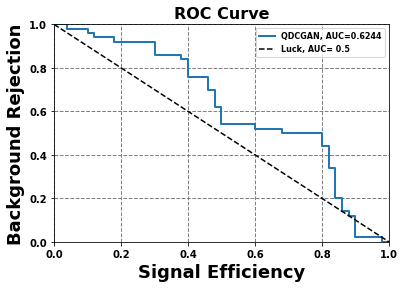

In [19]:
qgan.test(x_test, y_test)

So we see that with the particular quantum data encoder, generator and discriminator circuits used and with the specific hyperparmeters, we got a **test auc of roughly 0.6244**.

# Hyperparameter Tuning

After some trial and error, I figured the most important factor affecting the model performance is the **quantum circuits used and the learning rate** of both generator and discriminator. 

The choice of quantum data encoding circuit and PQCs for the generator and discriminator is still a hot research topic and there is no general consensus on what is best to use. So all we can do is to randomly construct some circuits of our choice. Preferrably the circuits should have at least one entanglement (i.e. two-qubit operators) layer so that the qubits can spread in a higher dimensional Hilbert space and make the model more complex.

For simpliity, a **grid search** will be used for hyperparameter tuning

In [20]:
# we first tune learning rate (just simple search space for sake of demonstration)
search_space = {
    'g_lr': [1e-2, 5e-3, 1e-3],
    'd_lr': [1e-2, 5e-3, 1e-3]
}

In [21]:
import itertools
categorical_combinations = [search_space[hp] for hp in search_space]
search_points = list(set(itertools.product(*categorical_combinations)))
search_points = [{hp:value for hp,value in zip(search_space.keys(), point)} for point in search_points]
search_points

[{'d_lr': 0.01, 'g_lr': 0.001},
 {'d_lr': 0.005, 'g_lr': 0.005},
 {'d_lr': 0.01, 'g_lr': 0.005},
 {'d_lr': 0.01, 'g_lr': 0.01},
 {'d_lr': 0.005, 'g_lr': 0.001},
 {'d_lr': 0.001, 'g_lr': 0.01},
 {'d_lr': 0.001, 'g_lr': 0.001},
 {'d_lr': 0.005, 'g_lr': 0.01},
 {'d_lr': 0.001, 'g_lr': 0.005}]

In [22]:
result = []
models = []
for point in search_points:
    print('INFO: Training QGAN with the hyperparameters: {}'.format(point))
    model = QGAN(generator_circuit, discriminator_circuit, encoding_circuit=encoding_circuit,
              epochs=100, g_activation='tanh', d_activation='linear',
              random_state=2, **point)
    model.train(x_train_sig, interactive_display=False)
    roc_auc = model.test(x_test, y_test, plot=False)
    print('INFO: Test AUC = {}'.format(roc_auc))
    result.append(roc_auc)
    models.append(model)

INFO: Training QGAN with the hyperparameters: {'g_lr': 0.001, 'd_lr': 0.01}
Summary of Generator
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_2 (PQC)                  (None, 5)                 70        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_3 (PQC)                  (None, 1)                 54        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 56
Trainable params: 56
Non-tr

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

In [23]:
result = np.array(result)
best_config_lr = search_points[np.argmax(result)]
print('The best lr combination so far is:')
print(best_config_lr)
print('With test auc = {}'.format(np.max(result)))

The best lr combination so far is:
{'g_lr': 0.01, 'd_lr': 0.001}
With test auc = 0.7544000000000001


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

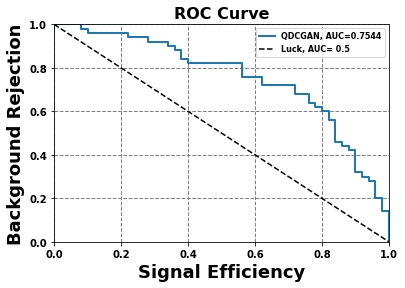

In [24]:
models[np.argmax(result)].test(x_test, y_test)

In [25]:
# we then tune quantum circuit
# for data encoding circuit, maybe try different entanglement, i.e. full entanglement and linear 
from quple.circuits.variational_circuits import IsingCoupling, EfficientSU2
encodirng_cq_1 = ParameterisedCircuit(n_qubit, copies=2,
                                    rotation_blocks=['H', 'RZ', 'RY'],
                                    entanglement_blocks=['CX'],
                                    parameter_symbol='x',
                                    reuse_param_per_layer=True,
                                    entangle_strategy='alternate_linear',
                                    name='encodirng_cq_1')
encodirng_cq_2 = ParameterisedCircuit(n_qubit, copies=2,
                                    rotation_blocks=['H', 'RZ', 'RY'],
                                    entanglement_blocks=['CX'],
                                    parameter_symbol='x',
                                    reuse_param_per_layer=True,
                                    entangle_strategy='alternate_linear',
                                    name='encodirng_cq_2')
# just some random choice for generator and discriminator with enough complexity
generator_cq_1 = IsingCoupling(n_qubit=n_qubit, copies=3, entangle_strategy='full', name='generator_cq_1')
generator_cq_2 = EfficientSU2(n_qubit=n_qubit, copies=4, entangle_strategy='full', name='generator_cq_2')

discrminator_cq_1 = ParameterisedCircuit(n_qubit=n_qubit, copies=3,
                                         rotation_blocks=['RZ', 'RY'],
                                         entanglement_blocks = [PauliBlock('ZZ'), PauliBlock('XX')],
                                         entangle_strategy='alternate_linear',
                                         name='discrminator_cq_1')
discrminator_cq_2 = ParameterisedCircuit(n_qubit=n_qubit, copies=3,
                                         rotation_blocks=['RZ'],
                                         entanglement_blocks = [PauliBlock('ZZ'), PauliBlock('ZZZ')],
                                         entangle_strategy='linear',
                                         name='discrminator_cq_2')
search_space_circuit = {
    'encoding_circuit': [encodirng_cq_1, encodirng_cq_2],
    'generator_circuit': [generator_cq_1, generator_cq_2],
    'discriminator_circuit': [discrminator_cq_1, discrminator_cq_2]
}

In [26]:
categorical_combinations = [search_space_circuit[hp] for hp in search_space_circuit]
points = list(itertools.product(*categorical_combinations))
search_points_circuit = [{hp:value for hp,value in zip(search_space_circuit.keys(), point)} for point in points]
#the __str__ of cirq circuit will print the circuit structure by default so should print quple.QuantumCircuit.name instead
search_points_str = [{hp:value.name for hp,value in zip(search_space_circuit.keys(), point)} for point in points]
#print out the list of search points
search_points_str

[{'discriminator_circuit': 'discrminator_cq_1',
  'encoding_circuit': 'encodirng_cq_1',
  'generator_circuit': 'generator_cq_1'},
 {'discriminator_circuit': 'discrminator_cq_2',
  'encoding_circuit': 'encodirng_cq_1',
  'generator_circuit': 'generator_cq_1'},
 {'discriminator_circuit': 'discrminator_cq_1',
  'encoding_circuit': 'encodirng_cq_1',
  'generator_circuit': 'generator_cq_2'},
 {'discriminator_circuit': 'discrminator_cq_2',
  'encoding_circuit': 'encodirng_cq_1',
  'generator_circuit': 'generator_cq_2'},
 {'discriminator_circuit': 'discrminator_cq_1',
  'encoding_circuit': 'encodirng_cq_2',
  'generator_circuit': 'generator_cq_1'},
 {'discriminator_circuit': 'discrminator_cq_2',
  'encoding_circuit': 'encodirng_cq_2',
  'generator_circuit': 'generator_cq_1'},
 {'discriminator_circuit': 'discrminator_cq_1',
  'encoding_circuit': 'encodirng_cq_2',
  'generator_circuit': 'generator_cq_2'},
 {'discriminator_circuit': 'discrminator_cq_2',
  'encoding_circuit': 'encodirng_cq_2',
  

In [27]:
result_cq = []
models_cq = []
for i, point in enumerate(search_points_circuit):
    print('INFO: Training QDCGAN with the hyperparameters: {}'.format(search_points_str[i]))
    model = QGAN(**point,
              epochs=100, g_activation='tanh', d_activation='linear',
              random_state=2, **best_config_lr)
    model.train(x_train_sig, interactive_display=False)
    roc_auc = model.test(x_test, y_test, plot=False)
    print('INFO: Test AUC = {}'.format(roc_auc))
    result_cq.append(roc_auc)
    models_cq.append(model)

INFO: Training QDCGAN with the hyperparameters: {'encoding_circuit': 'encodirng_cq_1', 'generator_circuit': 'generator_cq_1', 'discriminator_circuit': 'discrminator_cq_1'}
Summary of Generator
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_20 (PQC)                 (None, 5)                 70        
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 30        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_21 (PQC)                 (None, 1)                 54        
_________________________________________________________________
dense_21 (De

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

<Figure size 1152x648 with 0 Axes>

In [28]:
result_cq = np.array(result_cq)
best_config_circuit = search_points_str[np.argmax(result_cq)]
print('The best circuit combination so far is:')
print(best_config_circuit)
print('With test auc = {}'.format(np.max(result_cq)))

The best circuit combination so far is:
{'encoding_circuit': 'encodirng_cq_1', 'generator_circuit': 'generator_cq_1', 'discriminator_circuit': 'discrminator_cq_1'}
With test auc = 0.7544000000000001


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

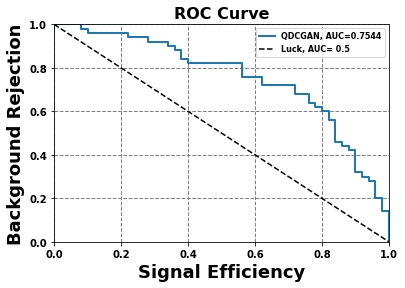

In [29]:
models_cq[np.argmax(result_cq)].test(x_test, y_test)

## Quantum Wasserstein GAN (QWGAN)

- Here we may also play with quantum version of other GAN model such as the **Wasserstein GAN**

- It is mostly similar to the original GAN except **replacing the binary cross entropy loss by the Wasserstein distance** and introduce the **number of discriminator steps per generator step** concept

- In an advanced version: WGAN-GP (GAN with gradient penalty). A **gradient pentaly** is added to the loss which helps in peroformance. However, as explained in the introduction, `tensorflow_quantum` currently **does not support 2nd order derivative** so it is implemented but not enabled in this notebook.

In [30]:
from typing import Union, Optional
from functools import partial

import cirq
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_quantum as tfq
from tqdm import tqdm

import quple
from quple.interface.tfq.layers.pqc import PQC

class QWGAN(object):
    """Quantum Wasserstein Generative Adversarial Network (QWGAN)
    """    
    def __init__(self, generator_circuit:"cirq.Circuit", discriminator_circuit:"cirq.Circuit",
                 encoding_circuit:"cirq.Circuit",
                 epochs:int=100, batch_size:int=10, n_critic:int=5, weight_gp:float=10, 
                 g_lr:float=1e-4, d_lr:float=1e-4, g_activation='tanh', 
                 d_activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                 #tf.keras.layers.LeakyReLU(alpha=0.01)
                 g_readout=None,
                 d_readout=None,                 
                 differentiator:Optional[tfq.differentiators.Differentiator]=None,
                 regularizer=None,
                 repetitions=None,                 
                 random_state:Optional[int]=None, 
                 name:str='QWGAN', *arg, **args):
        """ Creates a QWGAN model equipped with a generator and a discriminator
        Args:
            generator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum generator (VQG)
            discriminator: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit as a variational quantum discriminator (VQD)
            encoding_circuit: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit for data encoding             
            epochs: int, default=100
                Number of epochs
            batch_size: int, default=10
                Batch size for training
            n_critic: int, default=5
                Number of critic (discriminator) iterations to run for every generator iteration
            weight_gp: float, default=10
                The weight of gradient penalty (i.e. lambda) to use
            g_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the generator
            d_lr: float, default=1e-4
                Learning rate for the Adam optimizer of the discriminator
            g_activation: str/callable, default='tanh'
                Activation function for the output layer of generator
            d_activation: str/callable, default=LeakyReLU
                Activation function for the output layer of discriminator 
            g_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator
                If None, defaults to Pauli Z on all qubits
            d_readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects, default=None
                Measurement operators (observables) for the variational circuit layer of generator                     
                If None, defaults to Pauli Z on first qubit
            differentiator: Optional `tfq.differentiator` object 
                To specify how gradients of variational circuit should be calculated.
            regularizer: Optional `tf.keras.regularizer` object
                Regularizer applied to the parameters of the variational circuit.
            repetitions: int; default=None
                Number of repetitions for measurement           
            random_state: Optional int, default=None
                The random state for reproducible result.
            name: Optional str, default="QWGAN"
                Name given to the classifier.                
        """
        # initialize hyperparameters first
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_critic = n_critic
        self.weight_gp = weight_gp
        self.g_lr = g_lr
        self.d_lr = d_lr        
        self.g_activation = g_activation
        self.d_activation = d_activation
        self.differentiator = differentiator
        self.regularizer = regularizer
        self.repetitions = repetitions
        self.g_readout = g_readout
        self.d_readout = d_readout
        self.encoding_circuit = encoding_circuit
        # latent dimension is the same as number of features (= number of qubits)
        self.latent_dim = len(quple.get_circuit_qubits(encoding_circuit))
        self.random_state = random_state
        self.set_random_state(self.random_state)
        # create generator and discriminator models from parameterized quantum circuit
        self.G = self.create_generator(generator_circuit)
        self.D = self.create_discriminator(discriminator_circuit)
        # create optimizers
        self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=self.g_lr)
        self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=self.d_lr)
        
        self.name = name
        
        print('Summary of Generator')
        self.G.summary()
        
        print('Summary of Discriminator')
        self.D.summary()     
        
    @staticmethod
    def set_random_state(random_state=None):
        tf.random.set_seed(random_state)
        np.random.seed(random_state)               
        
    def create_generator(self, quantum_circuit:"cirq.Circuit"):
        generator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.g_readout:
            g_readout = [cirq.Z(qubit) for qubit in qubits]
        else:
            g_readout = self.g_readout
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        g_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for processing quantum output
        output_layer = tf.keras.layers.Dense(self.latent_dim, activation=self.g_activation)
        
        # create generator model
        generator.add(input_layer)
        generator.add(pqc_layer)
        generator.add(output_layer)
        return generator
    
    def create_discriminator(self, quantum_circuit:"cirq.Circuit"):
        discriminator = Sequential()
        # input layer for feeding classical data
        input_layer = tf.keras.layers.Input(shape=(self.latent_dim), dtype=tf.float32)        
        # variational layer 
        qubits = quple.get_circuit_qubits(quantum_circuit)
        if not self.d_readout:
            # by default measure PauliZ on first qubit
            d_readout = [cirq.Z(qubits[0])]
        else:
            d_readout = self.d_readout    
        pqc_layer = PQC(quantum_circuit,
                        self.encoding_circuit,
                        d_readout,
                        repetitions=self.repetitions,
                        differentiator=self.differentiator,
                        regularizer=self.regularizer)
        # classical layer for adding bias to the quantum output
        output_layer = tf.keras.layers.Dense(1, activation=self.d_activation)
        
        # create generator model
        discriminator.add(input_layer)
        discriminator.add(pqc_layer)
        discriminator.add(output_layer)
        return discriminator
    
    def D_loss(self, real_output, fake_output):
        """Compute discriminator loss."""
        return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

    def G_loss(self, fake_output):
        """Compute generator loss."""
        return -tf.reduce_mean(fake_output)
    
    @tf.function 
    def G_step(self):
        """Perform one training step for generator"""
        # using Gaussian noise with mean 0 and width 1 as generator input
        noise = tf.random.normal((self.batch_size, self.latent_dim))
        with tf.GradientTape() as t:
            x_fake = self.G(noise, training=True)
            fake_output = self.D(x_fake, training=True)
            loss = self.G_loss(fake_output)
        grad = t.gradient(loss, self.G.trainable_variables)
        self.G_optimizer.apply_gradients(zip(grad, self.G.trainable_variables))
        return loss
    
    @tf.function
    def D_step(self, x_real):
        """Perform one training step for discriminator"""
        x_real = tf.dtypes.cast(x_real, tf.float32)
        # using Gaussian noise with mean 0 and width 1 as generator input
        noise = tf.random.normal(x_real.shape, dtype=tf.float32)
        with tf.GradientTape() as t:
            x_fake = self.G(noise, training=True)
            real_output = self.D(x_real, training=True)
            fake_output = self.D(x_fake, training=True)
            # compute Wasserstein loss: (x_fake - x_real) + gp_weight*gradient_term
            cost = self.D_loss(real_output, fake_output)
            # since tfq does not supoprt 2nd order derivative we can't evaluate
            # cost with gradient penalty for the moment
            #gp = self.gradient_penalty(partial(self.D, training=True), x_real, x_fake)
            #cost = self.weight_gp * gp
        grad = t.gradient(cost, self.D.trainable_variables)
        self.D_optimizer.apply_gradients(zip(grad, self.D.trainable_variables))
        return cost  

    @tf.function
    def gradient_penalty(self, f, x_real, x_fake):
        alpha = tf.random.uniform([self.batch_size, 1], 0., 1.)
        diff = x_fake - x_real
        inter = x_real + (alpha * diff)
        with tf.GradientTape() as t:
            t.watch(inter)
            pred = f(inter)
        grad = t.gradient(pred, [inter])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=1))
        gp = tf.reduce_mean((slopes - 1.)**2)
        return gp    
    
    @tf.function
    def generate_samples(self, batch_size):
        """Generates sample using random inputs."""
        z = tf.random.normal((batch_size, self.latent_dim))
        return self.G(z, training=False)  
    
    def predict(self, x):
        return self.D(x, training=False) 
    
    @staticmethod
    def create_batches(x, batch_size, buffer_size=10000):
        batches = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)
        return batches
    
    def train(self, x, interactive_display=True):
        self.set_random_state(self.random_state)
        batches = self.create_batches(x, self.batch_size)
        #sample_size = x.shape[0]
        #z = tf.constant(tf.random.normal((sample_size, self.latent_dim)))
        g_metric = tf.keras.metrics.Mean()
        d_metric = tf.keras.metrics.Mean()
        fig = plt.figure(figsize=(16,9))
        g_loss_arr = []
        d_loss_arr = []
        epoch_arr = []
        
        for epoch in range(self.epochs):
            for batch in batches:
                for _ in range(self.n_critic):
                    d_loss = self.D_step(batch)
                    d_metric(d_loss)
                g_loss = self.G_step()
                g_metric(g_loss)
                
            g_loss_arr.append(g_metric.result())
            d_loss_arr.append(d_metric.result())
            epoch_arr.append(epoch)
            
            if interactive_display:
                self.display_loss(g_loss_arr, d_loss_arr, epoch_arr)
            g_metric.reset_states()
            d_metric.reset_states()
            
        if not interactive_display:
            return g_loss_arr, d_loss_arr
            
    def test(self, x, y, plot=True):
        score = self.predict(x)
        fpr, tpr, thresholds = roc_curve(y, score)
        roc_auc = auc(fpr, tpr)
        if plot:
            return plot_roc_curve(fpr, tpr, 'QWGAN')
        else:
            return roc_auc
        
    def display_loss(self, g_loss, d_loss, epochs):
        ax = plt.gca()
        ax.set_xlim(0, 1.1*epochs[-1])
        ax.cla()
        ax.plot(epochs, g_loss, label="Generator")
        ax.plot(epochs, d_loss, label="Discriminator")
        ax.set_xlabel('Epoch', fontsize=20)
        ax.set_ylabel('Wasserstein Loss', fontsize=20)
        ax.grid(True)
        ax.legend(fontsize=20)
        display(plt.gcf())
        clear_output(wait = True)    

In [31]:
qwgan = QWGAN(generator_circuit, discriminator_circuit, encoding_circuit=encoding_circuit,
              epochs=100, d_lr=1e-4, g_lr=1e-3, g_activation='tanh', d_activation='linear',
              random_state=2)
#tf.keras.layers.LeakyReLU(alpha=0.1)

Summary of Generator
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_36 (PQC)                 (None, 5)                 70        
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 30        
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Summary of Discriminator
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_37 (PQC)                 (None, 1)                 54        
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 2         
Total params: 56
Trainable params: 56
Non-trainable params: 0
________________________________________________________

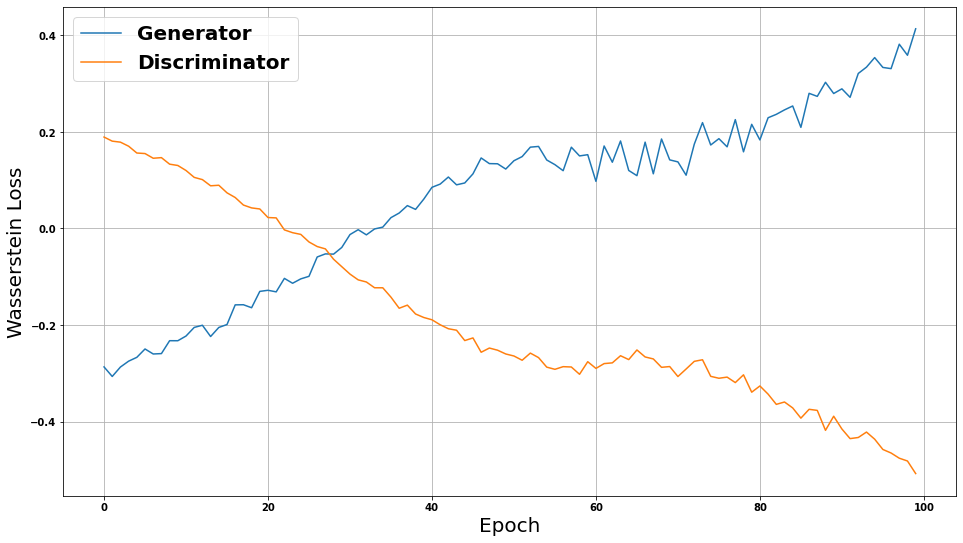

In [32]:
qwgan.train(x_train_sig)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

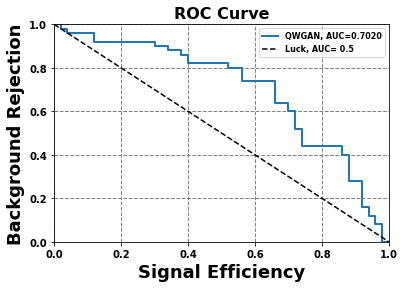

In [33]:
qwgan.test(x_test, y_test)

### Comparison of generated samples and true samples

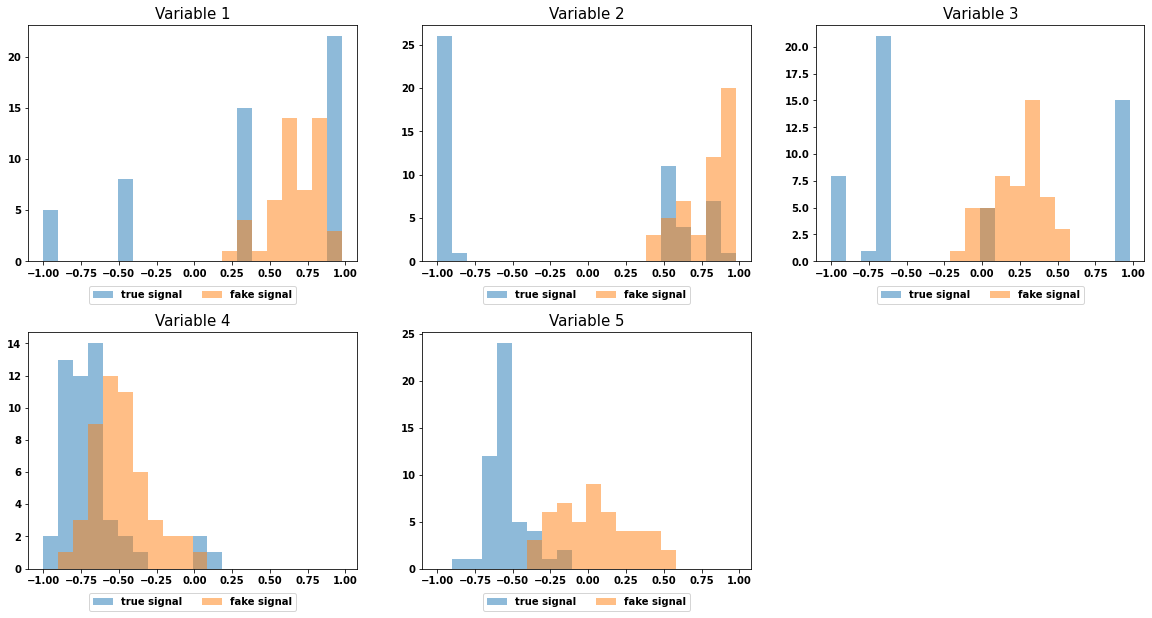

In [34]:
samples = qwgan.generate_samples(batch_size=50).numpy()
make_plots([x_train_sig, samples], ['true signal', 'fake signal'])

Other things to investigate:

- Use of different **differentiators** from `tensorflow_quantum`. For example the `tfq.differentiators.ParameterShift()` method which can potentially give good performance but with a faster execution time.